# Ma 17

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
import sympy as sym
from sympy import sympify
import scipy.stats as stats

In [58]:
#Prints a value with its error in scientific notation up to its 2 decimal
def print_scientific(value,error):
    """
    value (float) : the value
    error (float) : the error
    
    Returns:
        (string) : formatted string with the value an error
    """
    base10_error=int(np.floor(np.log10(error)))
    base10_value=int(np.floor(np.log10(np.abs(value))))
    digits=int(base10_value-base10_error+1)
    if digits<=0:
        digits=0
    base=10**base10_value
    string=f"({value/base:.{digits}f} ± {error/base:.{digits}f})·10^{base10_value}"
    return string

In [59]:
def compute_error(expression, variables, values, errors):
    """
    expression (string) : expression you used to compute the value
    variables  (list of strings) : list of variables that are in the expression in string form
    values     (list of float)   : list of values that go in the expression
    errors     (list of float)   : list of errors for each value
    
    Returns: (result, uncertainty) : tuple with the desired value and its uncertainty
    
    !! ATTENTION: Length variables = length values = length errors
    
    An example: 
    >   expression="x**2+y"
    >   var=["x","y"]; values=[2,1]; errors=[4,2]
    >   compute_error(expression, var, values, errors)
    """
    #Make variables and expression symbolic
    expression=sym.sympify(expression)
    variables=sym.symbols(variables)
    
    #To store coefficients
    coefficients=[]
    
    for index,variable in enumerate(
        variables):
        dexpression=sym.diff(expression, variable) #Differentiates expression
        coefficient=dexpression.subs(list(zip(variables, values))) #substitution
        coefficients.append(errors[index]*np.float64(coefficient)) #multiply coefficient times error
    
    uncertainty=np.sqrt(np.sum(np.array(coefficients)**2))
    result=np.float64(expression.subs(list(zip(variables, values))))

    return result,uncertainty
    

## Computing the mass of the monolayer

Text(0, 0.5, 'Frequency (Hz)')

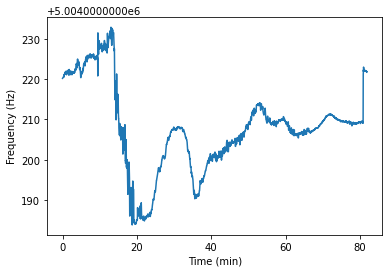

In [60]:
#Load dataframe
df=pd.read_csv(f"data/MUA-monolayer.csv", sep=";")
frequency=np.array(df["Frequency"])
time=np.array(df["Time (s)"])
plt.plot(time/60, frequency)
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

### Baseline drift ethanol

Text(0, 0.5, 'Frequency (Hz)')

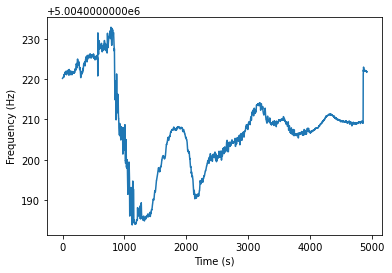

In [140]:
plt.plot(time, frequency)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

To compute the regression we will use the first seconds until the maximum.

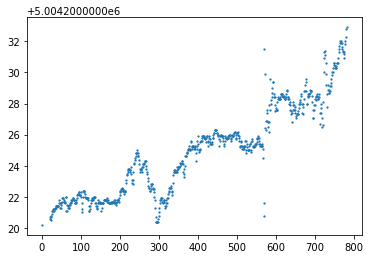

In [106]:
maxtime=time[frequency==np.max(frequency)][0]
freq_eth=frequency[time<=maxtime]
time_eth=time[time<=maxtime]
plt.scatter(time_eth, freq_eth, s=1.5)

Notice how there is an area of large noise between 500 and 600, I believe that here is where professor Arataka moved the liquid. We have to take it out.

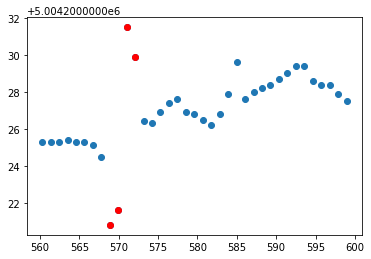

In [135]:
inspection=[time>560 and time<600 for time in time_eth]
to_delete=[time>568 and time<573 for time in time_eth]
plt.scatter(time_eth[inspection], freq_eth[inspection])
plt.scatter(time_eth[to_delete],freq_eth[to_delete], color="red")

We identify them as the four data points between 569 and 572

In [136]:
selection=np.array([time<568 or time>573 for time in time_eth])

In [137]:
linregression= stats.linregress(time_eth[selection], freq_eth[selection])
linregression_eth=linregression

In [138]:
print(f"We obtain a regression with slope "+print_scientific(linregression.slope,linregression.stderr)+" s^-2")
print(f"and an intercept of "+print_scientific(linregression.slope,linregression.intercept_stderr)+" Hz")
print(f"With a p-value of {linregression.pvalue:.2E}<<0.05, for the null hypothesis: the slope is 0")
print(f"Finally the r^2 score is {linregression.rvalue:.2f}")

We obtain a regression with slope (1.232 ± 0.018)·10^-2 s^-2
and an intercept of (1.2 ± 8.1)·10^-2 Hz
With a p-value of 1.32E-318<<0.05, for the null hypothesis: the slope is 0
Finally the r^2 score is 0.93


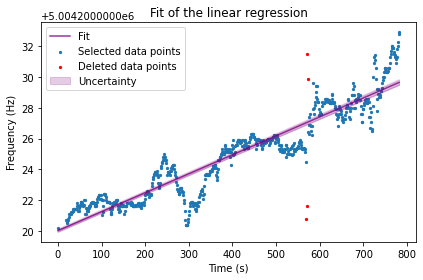

In [139]:
#Draw the graph with uncertainty in the slope
X=time_eth; Y=time_eth*linregression.slope+linregression.intercept;
uncertainty_regression=np.sqrt((X*linregression.stderr)**2+linregression.intercept_stderr**2)
plt.scatter(time_eth[selection], freq_eth[selection],s=5, label="Selected data points")
plt.scatter(time_eth[~selection], freq_eth[~selection],
            s=5,label="Deleted data points", color="red")
plt.plot(X,Y, color="purple", alpha=0.8, label="Fit")
plt.plot(X,uncertainty_regression+Y, color="purple", alpha=0.2)
plt.plot(X,Y-uncertainty_regression, color="purple", alpha=0.2)
plt.fill_between(X, Y+uncertainty_regression, Y-uncertainty_regression,
                color="purple", alpha=0.2, label="Uncertainty")
plt.legend()
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.title("Fit of the linear regression")
plt.tight_layout()

Still deleting this points does not do much and the slope obtained for this baseline is different from the one we obtained before. However it is in the same order of magnitude.

Anyhow, we will use this baseline to compute the frequency change.

## Mass computation

In [163]:
rho_q=2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q=0.001*(constants.gram)*(constants.centi)**(-3)
deltaf_L, stddeltaf_L=np.load("results/task1/Deltaf_experimental.npy")
d_q, stdd_q=np.load("results/task1/d_q.npy")
f_0, stdf_0=np.load("results/task1/eigenfreq_air.npy")
A=np.pi*(constants.inch/2)**2
deltaf_L=-deltaf_L

In [166]:
expression="-(rho_q*d_q*A)/(f_0)*(deltaf_L+deltaf_MUA)"

Text(0, 0.5, 'Frequency (Hz)')

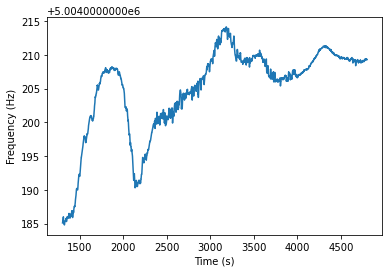

In [172]:
#We slice the array by eyeballing
selection_MUA=[time>=1300 and time<=4800 for time in time]
time_MUA=time[selection_MUA]
freq_MUA=frequency[selection_MUA]
plt.plot(time_MUA, freq_MUA)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")

In [174]:
deltaf_MUA=freq_MUA-(linregression_eth.slope*time_MUA+linregression.intercept)
mass=-(rho_q*d_q*A)/(f_0)*(deltaf_L+deltaf_MUA)

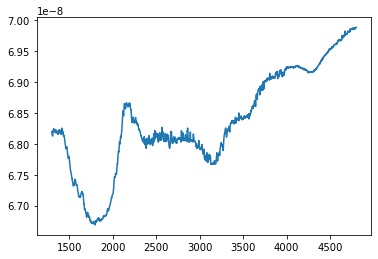

In [175]:
plt.plot(time_MUA, mass)
plt.xlabel("Time (s)")